In [1]:
import numpy as np 
import numpy.random as npr
import networkx as nx
import matplotlib as plt
import plotly.graph_objects as go
import pydtmc
import sys 
sys.path.append("./modules/")
from markov import *
import graphviz

In [2]:
# variables

alpha = 0.8
beta = 0.2
u1 = 15
u2 = 75
thinkTime = 5000
timeSlice = 3
Sio1 = 40
Sio2 = 180
qio1 = 0.65 #route to io1
qio2 = 0.25 # route to io2
qoutd = 0.1*0.4 #go to delay station
qouts = 0.1*0.6 # renter the system

legend (Delay_station,CPU.Stage,IO1,IO2)


Computing nodes for: 3,0,0,0
Discovered 2,1.1,0,0
Discovered 2,1.2,0,0
Computing nodes for: 2,1.1,0,0
Discovered 1,2.1,0,0
Discovered 2,0,0,1
Discovered 2,0,1,0
Discovered 3,0,0,0
Discovered 2,0,0,1
Discovered 2,0,1,0
Discovered 2,1.2,0,0
Discovered 3,0,0,0
Computing nodes for: 2,1.2,0,0
Discovered 2,0,0,1
Discovered 2,0,1,0
Discovered 3,0,0,0
Discovered 1,2.2,0,0
Discovered 2,0,0,1
Discovered 2,0,1,0
Discovered 3,0,0,0
Computing nodes for: 1,2.1,0,0
Discovered 0,3.1,0,0
Discovered 1,1.1,0,1
Discovered 1,1.1,1,0
Discovered 1,1.2,0,1
Discovered 1,1.2,1,0
Discovered 1,2.2,0,0
Computing nodes for: 2,0,0,1
Discovered 1,1.1,0,1
Discovered 1,1.2,0,1
Computing nodes for: 2,0,1,0
Discovered 1,1.1,1,0
Discovered 1,1.2,1,0
Computing nodes for: 3,0,0,0
Computing nodes for: 2,0,0,1
Discovered 1,1.1,0,1
Discovered 1,1.2,0,1
Computing nodes for: 2,0,1,0
Discovered 1,1.1,1,0
Discovered 1,1.2,1,0
Computing nodes for: 2,1.2,0,0
Discovered 1,2.2,0,0
Discovered 3,0,0,0
Computing nodes for: 3,0,0,0
Comput

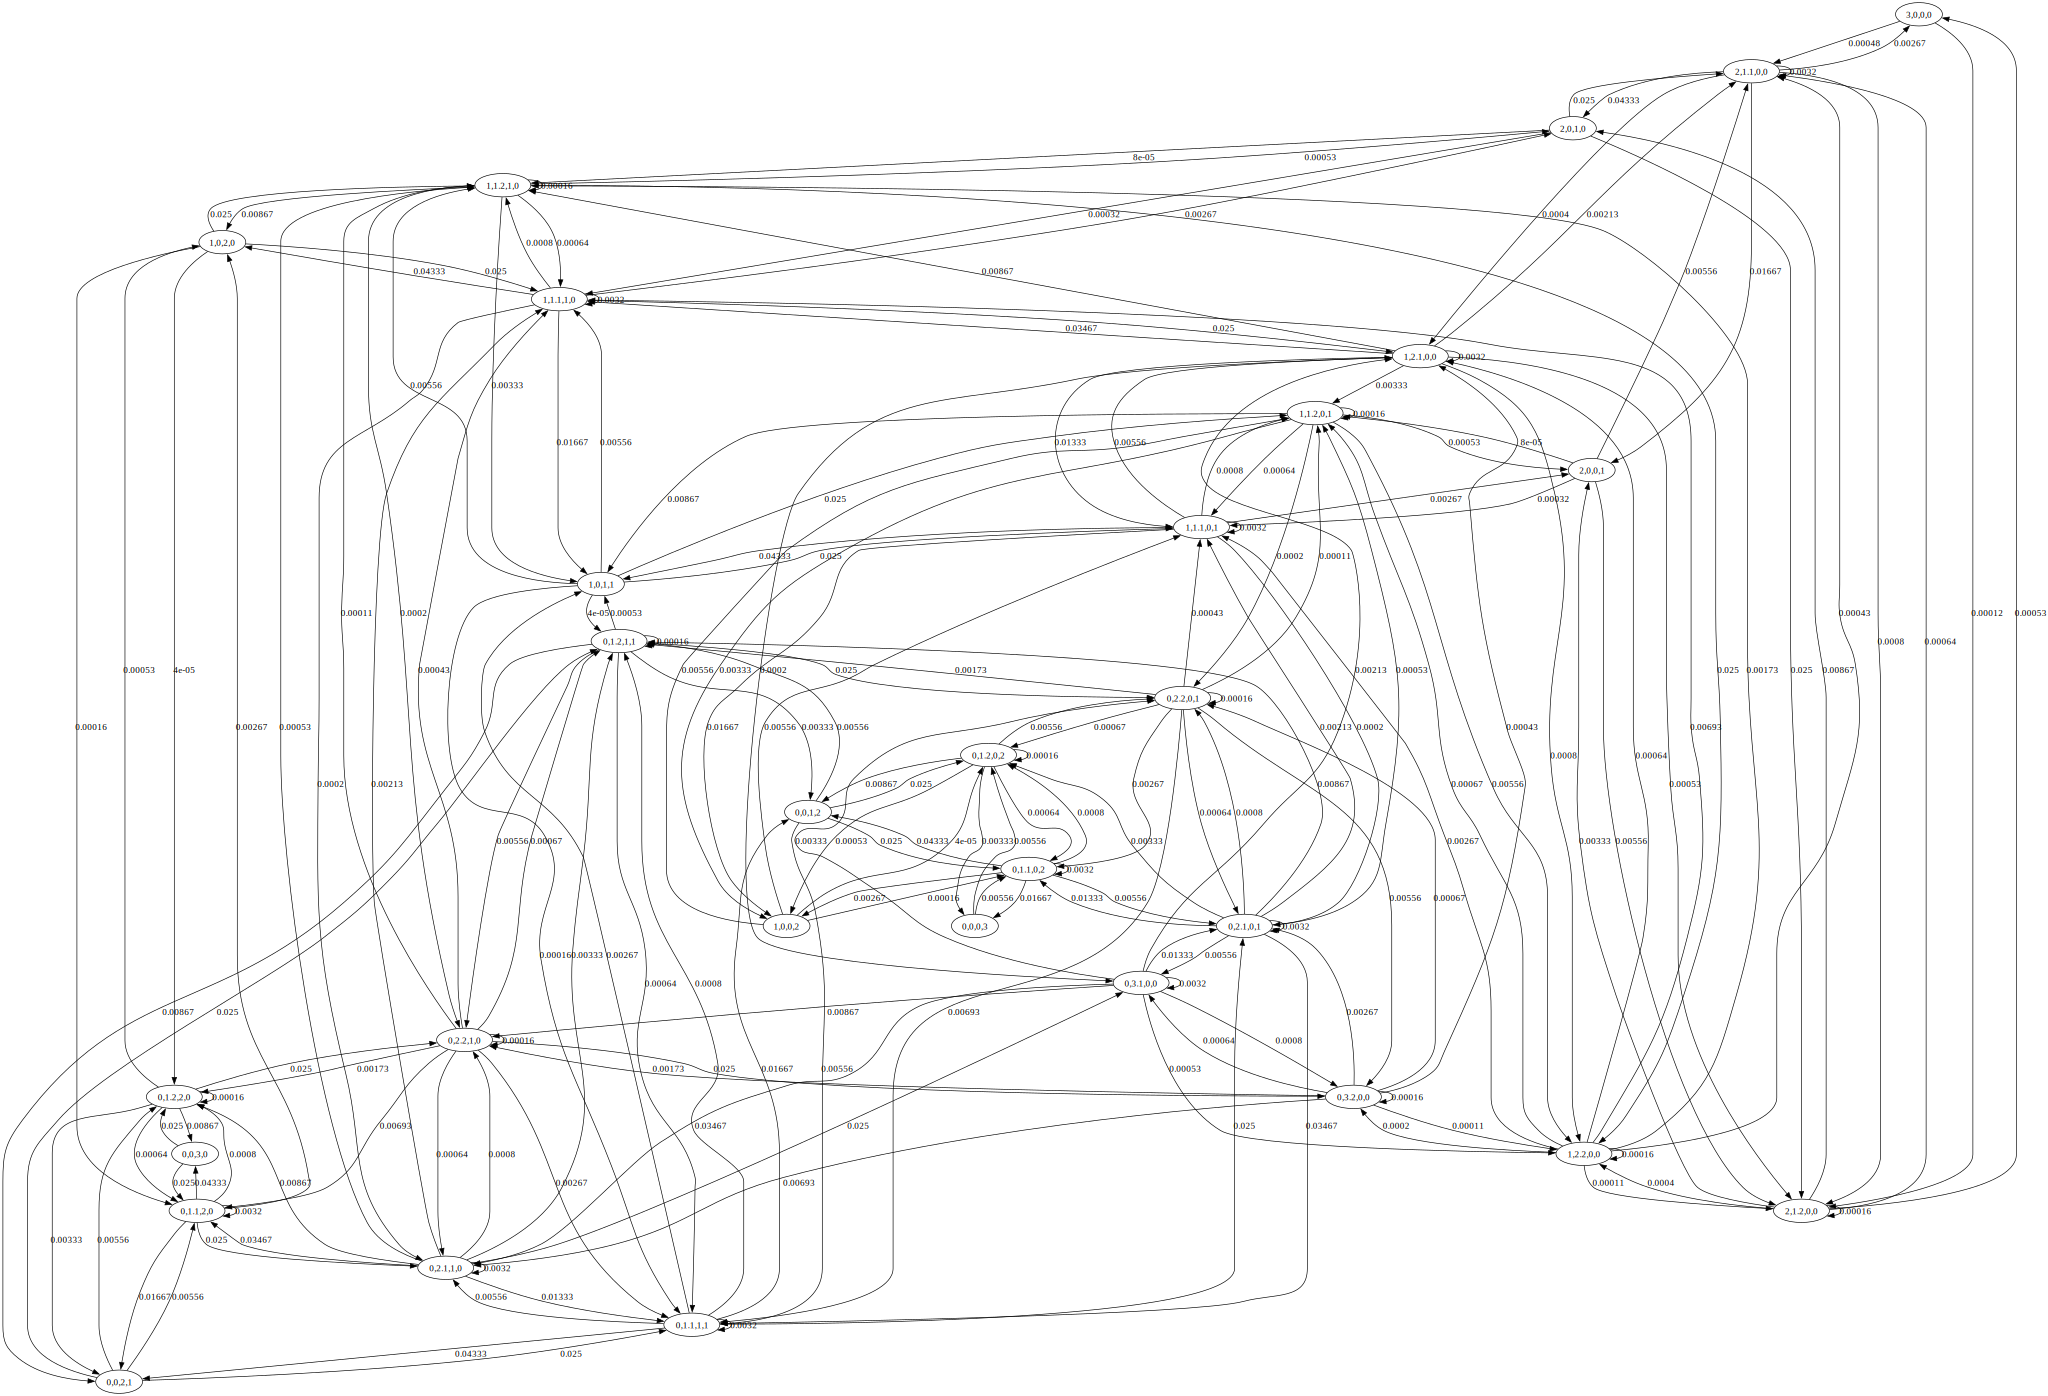

In [3]:
generator = ChainGenerator(node_enumerator())
generator(State(3,0,0,0))
chain = generator.chain()
Printer.nx_to_graphviz(chain)

Warning redundant edge 3,0,0,0 , 2,1.1,0,0 , call N 0, inW 0.00048, newW0.00048000000000000007
Warning redundant edge 2,0,0,1 , 2,1.1,0,0 , call N 0, inW 0.00556, newW0.005555555555555556
Warning redundant edge 2,0,1,0 , 2,1.1,0,0 , call N 0, inW 0.025, newW0.025
Warning redundant edge 2,1.2,0,0 , 2,1.1,0,0 , call N 0, inW 0.00064, newW0.00064
Warning redundant edge 3,0,0,0 , 2,1.1,0,0 , call N 0, inW 0.00048, newW0.00048000000000000007
Warning redundant edge 2,0,0,1 , 2,1.1,0,0 , call N 0, inW 0.00556, newW0.005555555555555556
Warning redundant edge 2,0,1,0 , 2,1.1,0,0 , call N 0, inW 0.025, newW0.025
Warning redundant edge 3,0,0,0 , 2,1.1,0,0 , call N 0, inW 0.00048, newW0.00048000000000000007
Warning redundant edge 2,0,0,1 , 2,1.1,0,0 , call N 0, inW 0.00556, newW0.005555555555555556
Warning redundant edge 2,0,1,0 , 2,1.1,0,0 , call N 0, inW 0.025, newW0.025
Warning redundant edge 3,0,0,0 , 2,1.1,0,0 , call N 0, inW 0.00048, newW0.00048000000000000007
Warning redundant edge 1,2.2,0,

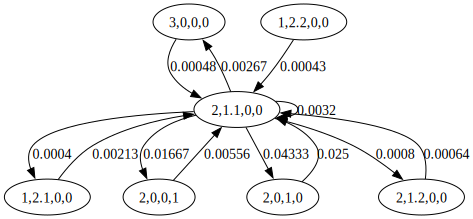

In [8]:
graph=  generator.subgraph(State(2,1,0,0,1))

Printer.nx_to_graphviz(graph)

In [9]:
nodes = list(map(lambda x : str(x),generator.ordered))
mat = np.zeros((len(nodes),len(nodes)))
adj :dict = chain.graph.adj
for i in range(len(nodes)):
    ref = nodes[i]
    for j in range(len(nodes)):
        to = nodes[j]
        if to in adj[ref]:
            mat[j][i] = adj[ref][to]["weight"]
        pass
    pass
pass

print("Birt:{},Death:{}".format(nodes[0],nodes[-1]))

for i in range(len(mat)):
    print(mat[i].sum())

    pass
print(mat.diagonal())

Birt:3,0,0,0,Death:0,0,3,0
{},{},{} 0.0 0.00048 0.00048
{},{},{} 0.0032 0.0008 0.0008
{},{},{} 0.00016 0.0 0.0
{},{},{} 0.0032 0.0 0.0
{},{},{} 0.0 0.0 0.0
{},{},{} 0.0 0.0 0.0
{},{},{} 0.0 0.0 0.0
{},{},{} 0.0 0.0 0.0
{},{},{} 0.0 0.025 0.025
{},{},{} 0.00016 0.00053 0.00053
{},{},{} 0.0 0.0 0.0
{},{},{} 0.0 0.0 0.0
{},{},{} 0.0 0.0 0.0
{},{},{} 0.0 0.0 0.0
{},{},{} 0.00016 0.0 0.0
{},{},{} 0.0 0.0 0.0
{},{},{} 0.0 0.0 0.0
{},{},{} 0.0 0.0 0.0
{},{},{} 0.0032 0.0 0.0
{},{},{} 0.0032 0.0 0.0
{},{},{} 0.0032 0.0 0.0
{},{},{} 0.00016 0.0 0.0
{},{},{} 0.00016 0.025 0.025
{},{},{} 0.00016 0.00267 0.00267
{},{},{} 0.0032 0.0008 0.0008
{},{},{} 0.00016 0.0 0.0
{},{},{} 0.0032 0.0008 0.0008
{},{},{} 0.00016 0.0 0.0
{},{},{} 0.0032 0.0008 0.0008
{},{},{} 0.00016 0.0 0.0
{},{},{} 0.0032 0.0008 0.0008
{},{},{} 0.00016 0.025 0.025
{},{},{} 0.00016 0.0 0.0
{},{},{} 0.0 0.0 0.0
{},{},{} 0.0032 0.0008 0.0008
{},{},{} 0.00016 0.0 0.0
{},{},{} 0.0032 0.0008 0.0008
{},{},{} 0.00016 0.0 0.0
{},{},{} 0.0

IndexError: index 1785 is out of bounds for axis 0 with size 1785

In [ ]:
dtmc = pydtmc.MarkovChain(mat)

ValidationError: The "p" parameter rows must sum to 1.0.

In [ ]:

(chain
("3,0,0,0","2,1.1,0,0",(1/thinkTime)*alpha*3, (1/u1)*qoutd)
(chain.last_tail,"1,2.1,0,0",(1/thinkTime)*2,(1/u1)*qoutd*alpha)
(chain.last_tail,"0,3.1,0,0",(1/thinkTime),(1/u1)*qoutd*alpha)
("3,0,0,0","2,1.2,0,0",(1/thinkTime)*beta*3,(1/u2)*qoutd)
(chain.last_tail,"1,2.2,0,0",(1/thinkTime)*2,(1/u2)*beta*qoutd)
(chain.last_tail,"0,3.2,0,0",(1/thinkTime),(1/u2)*beta*qoutd)
("0,3.1,0,0","0,2.1,1,0", (1/u1)*alpha*qio1,(1/u1)*alpha*qouts) 
(chain.last_tail, "0,1.1,2,0", (1/u1)*alpha*qio1,(1/Sio1))
(chain.last_tail, "0,0,3,0",(1/u1)*alpha*qio1,(1/Sio1))
("0,0,3,0","0,1.2,2,0",(1/Sio1)*beta,(1/u2)*qio1)
(chain.last_tail,"0,2.2,1,0",(1/Sio1),(1/u2)*qio2)
(chain.last_tail, "0,3.2,0,0",(1/Sio1),(1/u2)*qio1*beta)
("0,3.2,0,0","0,2.1,1,0",(1/u2)*alpha*qio1)
(chain.last_tail,"0,1.2,2,0",(1/u1)*beta*qio1)
("0,3.1,0,0","0,2.1,0,1",(1/u1)*alpha*qio2)
(chain.last_tail,"0,1.1,0,2",(1/u1)*alpha*qio2)
(chain.last_tail,"0,0,0,3",(1/u1)*alpha*qio2)
("0,3.2,0,0","0,2.2,0,1",(1/u2)*beta*qio2)
(chain.last_tail,"0,1.2,0,2",(1/u2)*beta*qio2)
(chain.last_tail,"0,0,0,3",(1/u2)*beta*qio2)
("0,3.2,0,0","0,2.1,0,1",(1/u2)*alpha*qio2)
(chain.last_tail,"0,1.2,0,2",(1/u2)*beta*qio2)
("0,3.1,0,0","0,2.2,0,1",(1/u1)*beta*qio2)
(chain.last_tail,"0,1.1,0,2",(1/u2)*alpha*qio2)
("0,1.1,0,2","0,0,1,2",(1/u1)*qio1)
("0,1.2,0,2","0,0,1,2",(1/u2)*qio1)
("0,1.1,2,0","0,0,2,1",(1/u1)*qio2)
("0,1.2,2,0","0,0,2,1",(1/u2)*qio2)
("0,2.2,1,0","0,1.2,1,1",(1/u2)*beta*qio2)
("0,2.2,1,0","0,1.1,1,1", (1/u2)*alpha*qio2)
("0,1.1,1,1","0,0,2,1",(1/u1)*qio1)
("0,1.2,1,1","0,0,2,1",(1/u2)*qio1)
("0,1.1,0,2","1,0,0,2",(1/u1)*qoutd)
("1,2.1,0,0","2,1.1,0,0",(1/u1)*alpha*qoutd)
("0,3.1,0,0","1,2.1,0,0",(1/u1)*alpha*qoutd)
("0,1.2,2,0","0,0,3,0",(1/u2)*qio1)
("0,0,2,1","0,1.1,2,0",(1/Sio2)*alpha*qouts)
("0,0,2,1","0,1.2,2,0",(1/Sio2)*qouts*alpha)
)

: 